In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import utils
utils.set_pretty_prints()

In [2]:
import torch as th
print("We have PyTorch version", th.__version__)

We have PyTorch version 1.4.0


In [3]:
bd = utils.load_dataset('california_housing')

Loading dataset 'california_housing' using 'fetch_california_housing' with normalize=True...
Data loaded:
  x_train    (16512, 8)
  y_train    (16512, 1)
  x_dev      (2064, 8)
  y_dev      (2064, 1)
  x_test     (2064, 8)
  y_test     (2064, 1)
  df         (20640, 8)
  desc       ".. _california_housing_dataset:California Housing dataset--------------------------**Data Set C"


In [8]:
bd.df.iloc[:20]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.9841,1.0238,322.0,2.5556,37.88,-122.23
1,8.3014,21.0,6.2381,0.9719,2401.0,2.1098,37.86,-122.22
2,7.2574,52.0,8.2881,1.0734,496.0,2.8023,37.85,-122.24
3,5.6431,52.0,5.8174,1.0731,558.0,2.5479,37.85,-122.25
4,3.8462,52.0,6.2819,1.0811,565.0,2.1815,37.85,-122.25
5,4.0368,52.0,4.7617,1.1036,413.0,2.1399,37.85,-122.25
6,3.6591,52.0,4.9319,0.9514,1094.0,2.1284,37.84,-122.25
7,3.1200,52.0,4.7975,1.0618,1157.0,1.7883,37.84,-122.25
8,2.0804,42.0,4.2941,1.1176,1206.0,2.0269,37.84,-122.26
9,3.6912,52.0,4.9706,0.9902,1551.0,2.1723,37.84,-122.25


In [9]:
print(bd.desc)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

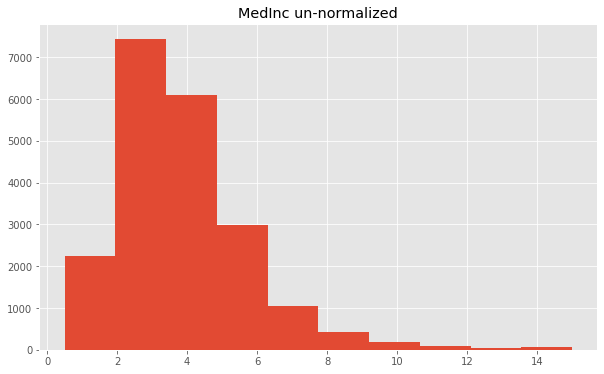

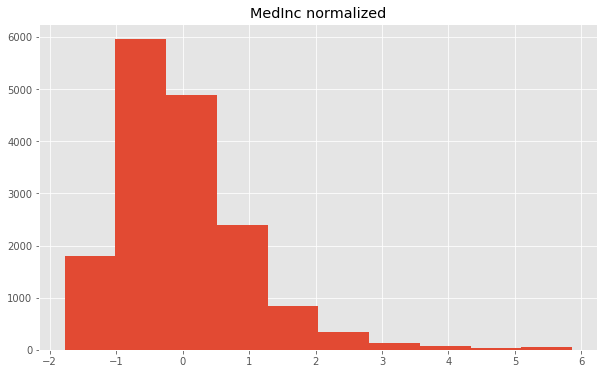

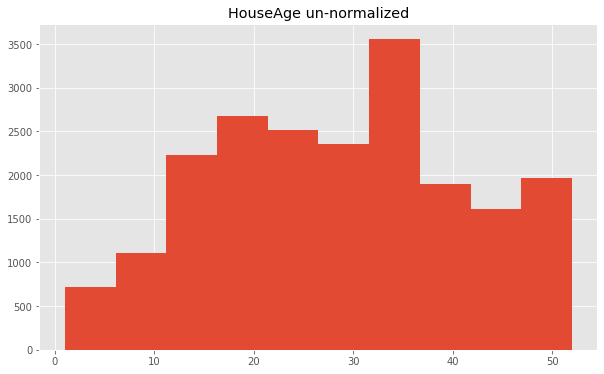

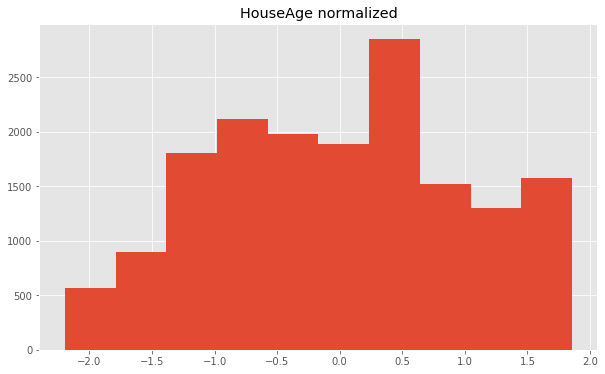

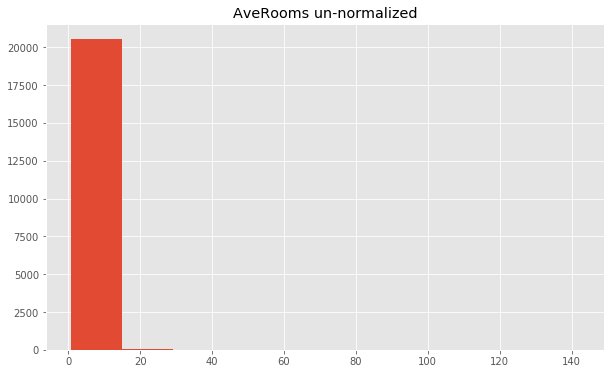

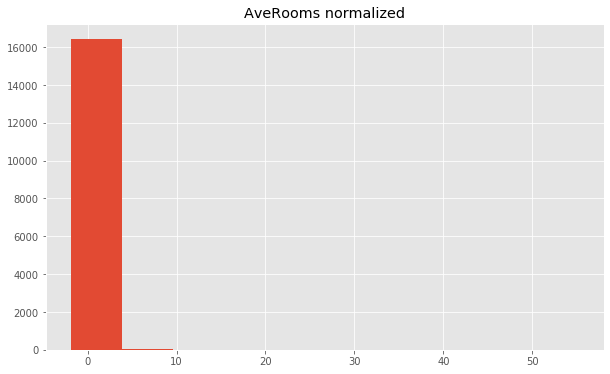

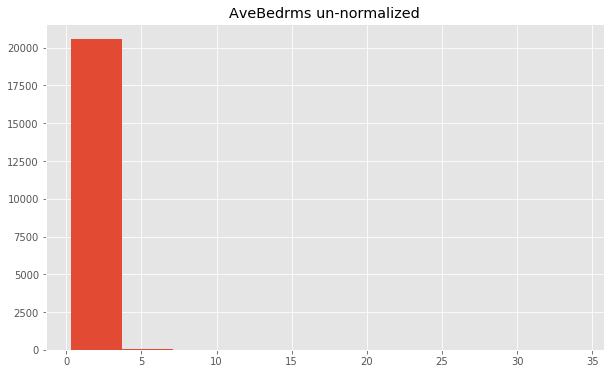

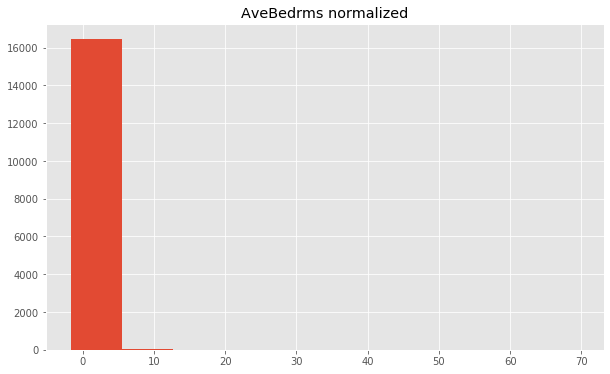

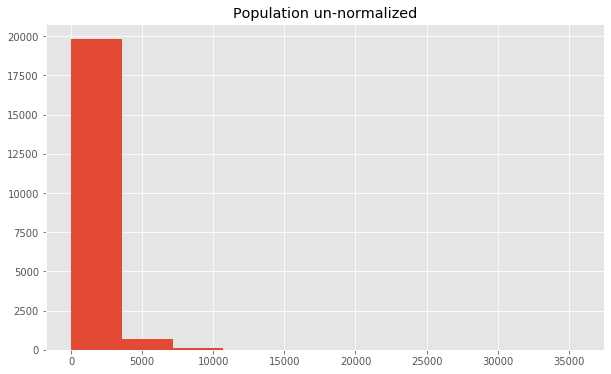

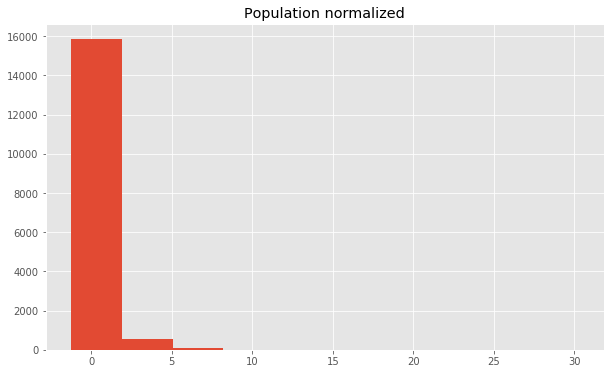

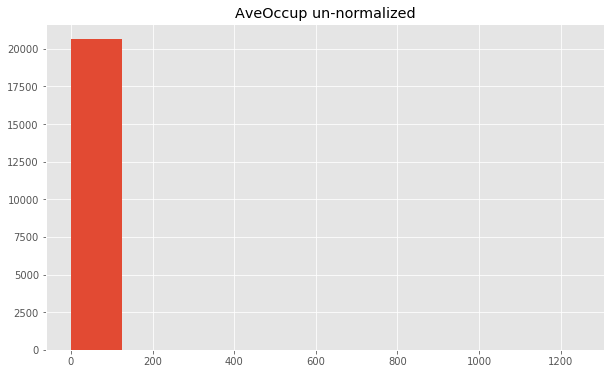

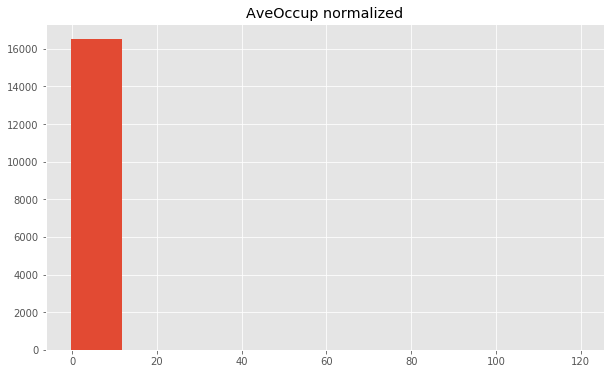

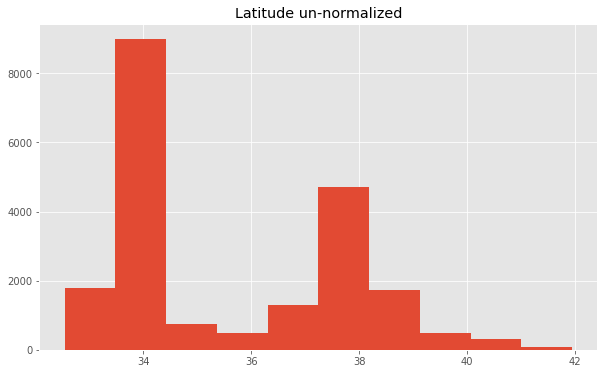

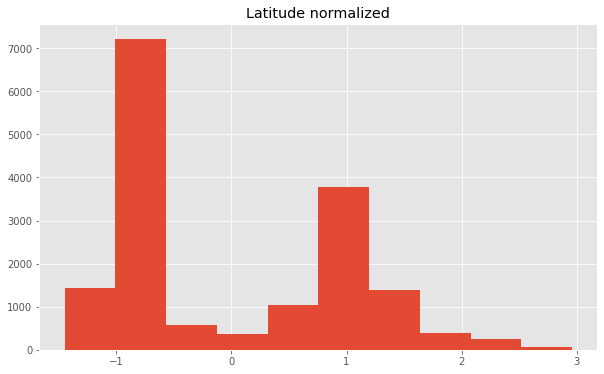

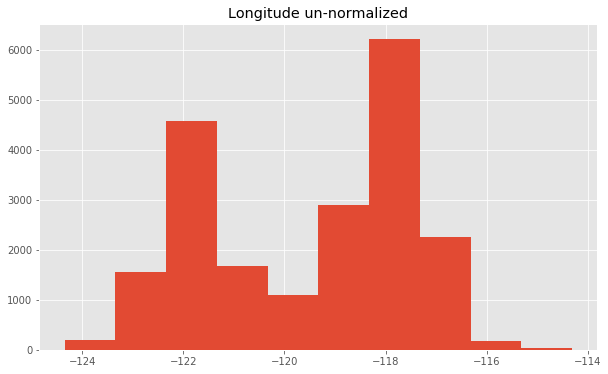

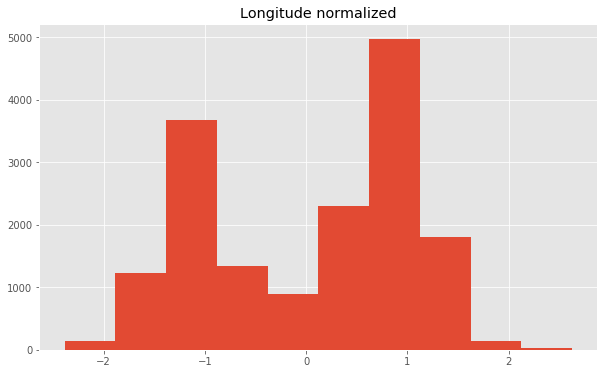

In [15]:
for i, column in enumerate(bd.df.columns):
    plt.figure(figsize=(10,6))
    bd.df[column].hist()    
    plt.title(column + ' un-normalized')
    plt.figure(figsize=(10,6))
    pd.Series(bd.x_train[:,i]).hist()
    plt.title(column + ' normalized')
    

Text(0.5, 1.0, 'Price histogram')

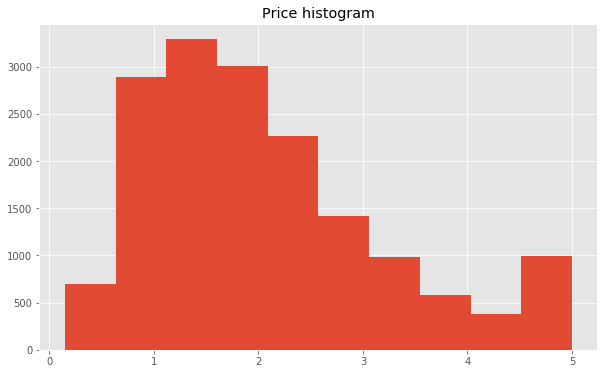

In [16]:
plt.figure(figsize=(10,6))
pd.Series(bd.y_train.reshape(-1)).hist()
plt.title('Price histogram')

In [73]:
def show_results(pred, gold, label=''):
    pred = pred.ravel()
    gold = gold.ravel()
    df_snapshot = pd.DataFrame({'PRED' : pred, 'TRUTH' : gold, 'AERR' : np.abs(gold-pred)})
    print("\nResults so far {}:\n{}".format(label, df_snapshot.iloc[:20]))
    print("Overall abs average error: {:.2f}".format(df_snapshot['AERR'].mean()))
    return df_snapshot


In [74]:
nr_feats = bd.x_train.shape[1]
th_coefs = th.zeros((nr_feats,1), requires_grad=True)
th_bias = th.zeros(1, requires_grad=True)

In [75]:
th_x_train = th.tensor(bd.x_train)
th_y_train = th.tensor(bd.y_train)


def predict(X):
    with th.no_grad():
        th_x = th.tensor(X)
        th_yh = th.mm(th_x, th_coefs) + th_bias
        yhat = th_yh.cpu().numpy()
        return yhat

In [76]:
th_ds = th.utils.data.TensorDataset(th_x_train, th_y_train)

In [77]:
batch_size = 10
th_dl = th.utils.data.DataLoader(th_ds, batch_size=batch_size)
epoch_len = bd.x_train.shape[0] // batch_size

In [78]:
nr_epochs = 20
lr = 0.01
y_rnd_preds = predict(bd.x_train)
res = show_results(y_rnd_preds, bd.y_train, label='RANDOM paras on TRAIN'.format(epoch))    

for epoch in range(1, nr_epochs + 1):
    epoch_losses = []
    for i, batch_data in enumerate(th_dl):
        th_x_batch, th_y_batch = batch_data
        th_preds = th.mm(th_x_batch, th_coefs) + th_bias
        th_batch_loss = (th_preds  - th_y_batch).abs()
        th_loss = th_batch_loss.mean()
        th_loss.backward()        
        with th.no_grad():
            th_coefs -= lr * th_coefs.grad
            th_bias -= lr * th_bias.grad
            th_coefs.grad.zero_()
            th_bias.grad.zero_()
            epoch_losses.append(th_loss.cpu().item())
        print("\rEpoch {} done {:.1f}% - avg loss: {:.3f}".format(epoch, i/epoch_len * 100, np.mean(epoch_losses)),
             end='', flush=True)
    print("")
    if (epoch % 5) == 0:  
        y_train_hat = predict(bd.x_train)
        res = show_results(y_train_hat, bd.y_train, label='at epoch {} on TRAIN'.format(epoch))    

        y_dev_hat = predict(bd.x_dev)
        res = show_results(y_dev_hat, bd.y_dev, label='at epoch {} on DEV'.format(epoch))    
        
y_test_hat = predict(bd.x_test)
res = show_results(y_test_hat, bd.y_test, label='at epoch {} on TEST'.format(epoch))            

Results so far RANDOM paras on TRAIN:
    PRED  TRUTH   AERR
0    0.0  1.125  1.125
1    0.0  4.024  4.024
2    0.0  3.034  3.034
3    0.0  1.582  1.582
4    0.0  2.822  2.822
5    0.0  1.865  1.865
6    0.0  2.250  2.250
7    0.0  0.756  0.756
8    0.0  0.662  0.662
9    0.0  0.911  0.911
10   0.0  1.625  1.625
11   0.0  2.424  2.424
12   0.0  1.342  1.342
13   0.0  2.464  2.464
14   0.0  3.455  3.455
15   0.0  3.386  3.386
16   0.0  2.579  2.579
17   0.0  2.445  2.445
18   0.0  4.833  4.833
19   0.0  5.000  5.000
Overall abs average error: 2.07
Epoch 1 done 100.0% - avg loss: 0.635
Epoch 2 done 100.0% - avg loss: 0.518
Epoch 3 done 100.0% - avg loss: 0.516
Epoch 4 done 100.0% - avg loss: 0.516
Epoch 5 done 100.0% - avg loss: 0.516
Results so far at epoch 5 on TRAIN:
      PRED  TRUTH    AERR
0   0.2442  1.125  0.8808
1   3.4900  4.024  0.5340
2   2.6592  3.034  0.3748
3   1.2610  1.582  0.3210
4   2.9171  2.822  0.0951
5   1.9278  1.865  0.0628
6   2.3231  2.250  0.0731
7   1.0979  0

In [84]:
lin_func = th.nn.Linear(8,1)
opt = th.optim.Adam(lin_func.parameters(), lr=0.01)

def predict2(X):
    with th.no_grad():
        th_x = th.tensor(X)
        th_yh = lin_func(th_x)
        return th_yh.cpu().numpy()
    
nr_epochs = 20
y_rnd_preds = predict2(bd.x_train)
res = show_results(y_rnd_preds, bd.y_train, label='RANDOM paras on TRAIN'.format(epoch))    

for epoch in range(1, nr_epochs + 1):
    epoch_losses = []
    for i, batch_data in enumerate(th_dl):
        th_x_batch, th_y_batch = batch_data
        th_preds = lin_func(th_x_batch)
        th_batch_loss = (th_preds  - th_y_batch).abs()
        th_loss = th_batch_loss.mean()
        opt.zero_grad()
        th_loss.backward()        
        opt.step()
        epoch_losses.append(th_loss.cpu().detach().numpy())
        print("\rEpoch {} done {:.1f}% - avg loss: {:.3f}".format(epoch, i/epoch_len * 100, np.mean(epoch_losses)),
             end='', flush=True)
    print("")
    if (epoch % 5) == 0:  
        y_train_hat = predict2(bd.x_train)
        res = show_results(y_train_hat, bd.y_train, label='at epoch {} on TRAIN'.format(epoch))    

        y_dev_hat = predict2(bd.x_dev)
        res = show_results(y_dev_hat, bd.y_dev, label='at epoch {} on DEV'.format(epoch))    
        
y_test_hat = predict2(bd.x_test)
res = show_results(y_test_hat, bd.y_test, label='at epoch {} on TEST'.format(epoch))            


Results so far RANDOM paras on TRAIN:
      PRED  TRUTH    AERR
0   0.4458  1.125  0.6792
1   0.0295  4.024  3.9945
2   0.4715  3.034  2.5625
3  -0.1587  1.582  1.7407
4  -0.1147  2.822  2.9367
5  -0.6288  1.865  2.4938
6   0.0304  2.250  2.2196
7  -0.4407  0.756  1.1967
8   0.1776  0.662  0.4844
9  -0.8445  0.911  1.7555
10 -0.0252  1.625  1.6502
11  0.4494  2.424  1.9746
12 -0.4946  1.342  1.8366
13 -0.0156  2.464  2.4796
14  0.4006  3.455  3.0544
15  0.0021  3.386  3.3839
16  0.4481  2.579  2.1309
17 -0.1146  2.445  2.5596
18  1.0185  4.833  3.8145
19  0.4790  5.000  4.5210
Overall abs average error: 2.11
Epoch 1 done 100.0% - avg loss: 0.620
Epoch 2 done 100.0% - avg loss: 0.521
Epoch 3 done 100.0% - avg loss: 0.521
Epoch 4 done 100.0% - avg loss: 0.521
Epoch 5 done 100.0% - avg loss: 0.521
Results so far at epoch 5 on TRAIN:
      PRED  TRUTH    AERR
0   0.2755  1.125  0.8495
1   3.4959  4.024  0.5281
2   2.7493  3.034  0.2847
3   1.3463  1.582  0.2357
4   2.8868  2.822  0.0648
5 

In [89]:
x_trn = np.hstack((bd.x_train,np.ones((bd.x_train.shape[0], 1))))
x_trn[:4]

array([[-1.18, -0.77,  0.58,  0.33, -1.08,  0.05, -1.35,  1.96,  1.  ],
       [ 1.52,  0.58,  0.7 ,  0.11, -0.76, -0.08,  1.06, -1.49,  1.  ],
       [ 1.29, -0.29,  1.04, -0.17, -0.2 , -0.02, -1.34,  1.31,  1.  ],
       [ 0.14, -1.24,  0.39, -0.11,  0.91, -0.04, -0.52,  1.16,  1.  ]])

In [99]:
np_coefs = np.linalg.pinv(x_trn.T.dot(x_trn)).dot(x_trn.T).dot(bd.y_train)
def show_feats(np_feats, caption):
    plt.figure(figsize=(10,6))
    plt.bar(np.arange(np_feats.shape[0]), np_feats, tick_label=list(bd.df.columns))
    plt.title(caption)

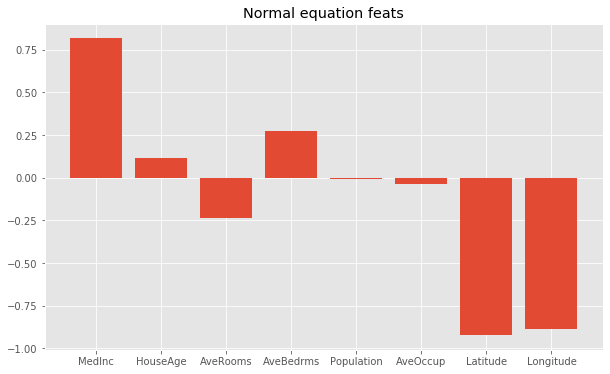

In [100]:
show_feats(np_coefs.ravel()[:-1], "Normal equation feats")


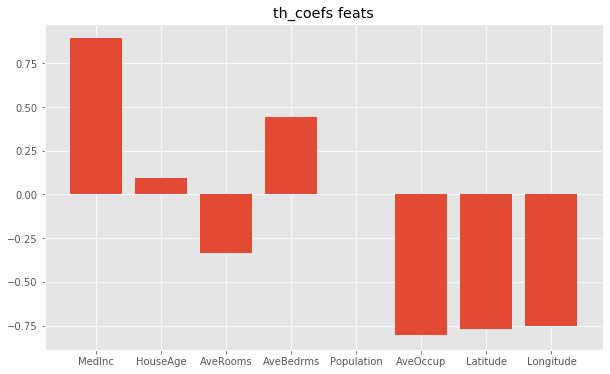

In [101]:
show_feats(th_coefs.detach().numpy().ravel(), "th_coefs feats")

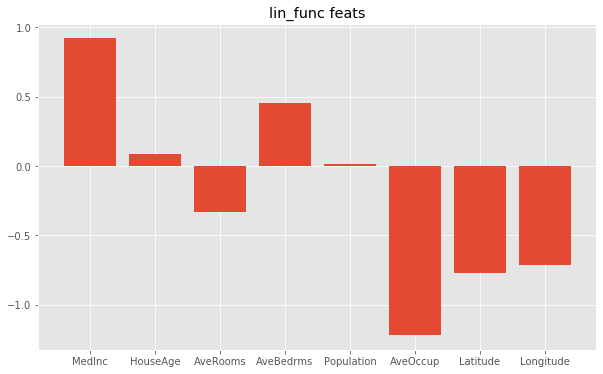

In [104]:
show_feats(lin_func.weight.detach().numpy().ravel(), "lin_func feats")

In [103]:
lin_func.weight

Parameter containing:
tensor([[ 0.9204,  0.0889, -0.3335,  0.4577,  0.0135, -1.2184, -0.7714, -0.7117]],
       requires_grad=True)